In [3]:
import pandas as pd
import numpy as np
# for Box-Cox Transformation
from scipy import stats


# plotting modules
import seaborn as sns
#import missingno

import matplotlib.pyplot as plt

Firstly we need to take a look at the dataset to see what information we're going to be working with.

In [10]:
titanic_data = pd.read_csv('Titanic.csv')
titanic_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### What kind of data do we have?

PassengerId -    [Integer][Categorical] 

Survived  -      [Integer][Categorical] 

Pclass    -      [Integer][Categorical] 

Name    -        [String][Categorical]

Sex     -        [String][Categorical]

Age    -         [Integer][Categorical] 

SibSp  -         [Integer][Categorical]

Parch  -         [Integer][Categorical]

Ticket -         [String][Categorical]

Fare   -         [Integer][Continuous]

Cabin  -         [String][Categorical]

Embarked  -      [String][Categorical]

From the data overview we instantly see a problem of quite a bit of missing data. How big is the problem, we need to use an "is_null" method to find out.

In [6]:
missing_values_count = titanic_data.isnull().sum()
missing_values_count

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

The missing data problem is isolated to 2 columns - Age & Cabin. The missing data for the cabin doesn't appear to be a problem for our analysis; we have have complete records for ticketing and passenger class that we can use to make inferences and conclusions. Even though the number of records is sizeable, the impact for this analysis is minimal.

The missing age data is a little bit more problematic as there doesn't seem to be a pattern or reason for the missing data and consequently not a way of imputing the data without creating a significant bias. We have a large enough sample size of available records to make meaningful conclusions and therefore we can just infer the "other/missing" data would follow the same patterns as the observed records.


### How can we add, change or remove features from your data to get more out of it

Moving left to right:

Firstly let's change the nature of the records in the survived column from integers to strings of "Yes" or "No".

Secondly replace all the missing age records with 0 and do the same for the cabin and embarked records.

Luckily from a data cleaning perspective this seems like all we have to do.

In [11]:
# cleaning the dataset to make it more usable - replacing 0 and 1 with yes and no for survived

titanic_data['Survived'] = titanic_data['Survived'].apply(str)
titanic_data['Survived'] = titanic_data['Survived'].replace("0","No")
titanic_data['Survived'] = titanic_data['Survived'].replace("1","Yes")

# filling missing values and replacing them with 0

titanic_data['Age'] = titanic_data['Age'].fillna(0)
titanic_data['Cabin'] = titanic_data['Cabin'].fillna(0)
titanic_data['Embarked'] = titanic_data['Embarked'].fillna(0)

titanic_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,No,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,Yes,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,Yes,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,Yes,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,No,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
5,6,No,3,"Moran, Mr. James",male,0.0,0,0,330877,8.4583,0,Q
6,7,No,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,No,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,0,S
8,9,Yes,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,0,S
9,10,Yes,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,0,C


### What is the most important factor of determining survival?

In [35]:
# filtering the dataset into smaller chunks to work with

# creating the survivors and fatalities dataset

survivors = titanic_data[titanic_data['Survived'] == 'Yes']

fatalities = titanic_data[titanic_data['Survived'] == 'No']

# isolating children in the relevant data sets

children = titanic_data.loc[(titanic_data['Age'] <= 18) & (titanic_data['Age'] > 0)]

survivor_children = survivors.loc[(titanic_data['Age'] <= 18) & (titanic_data['Age'] > 0)]

In [87]:
CH_Survive_percent = len(survivor_children)/ len(survivors)

Total_CH_percent = len(children) / len(titanic_data)

print(f"The proportion of children survivors is {CH_Survive_percent:.1%}, however the proportion of children in the passenger list is {Total_CH_percent:.1%}.\nThis indicates children were prioritised when loading people onto life boats.")

The proportion of children survivors is 20.5%, however the proportion of children in the passenger list is 15.6%.
This indicates children were prioritised when loading people onto life boats.


Now to check the gender proportions of total passengers and survivors

### Gender proportion of the total passenger list

<AxesSubplot: ylabel='Sex'>

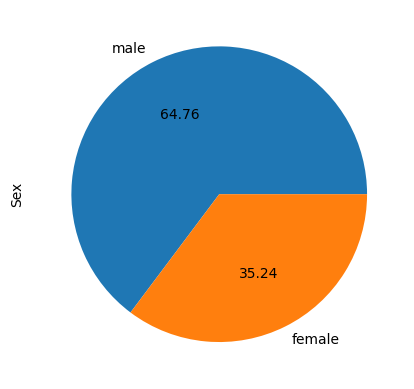

In [34]:
# pie chart to show gender proportions passengers
titanic_data['Sex'].value_counts().plot(kind='pie', autopct='%.2f')

### Gender proportion of the survivors

<AxesSubplot: ylabel='Sex'>

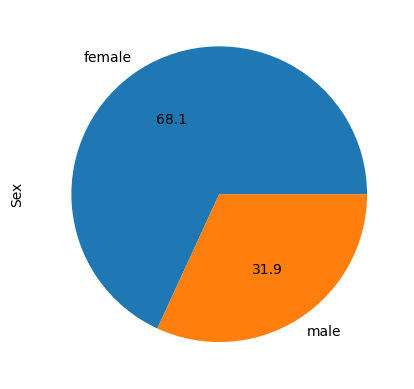

In [61]:
# pie chart to show gender proportions of survivors

survivors['Sex'].value_counts().plot(kind='pie', autopct='%.1f')

The disparity in the proportions between the two sample datasets in stark. Females make up 35% of the total passengers and make up 68% of the survivors, whereas Males are 65% of the passenger list but only 32% of the survivors.

Couple this with the higher than average representation of children in the survivor list, this indeed suggests women and children were prioritised above all others.

### Given the stark difference in the gender proportions I would conclude the biggest determining factor of survival was gender.

Now to check whether upper class passengers were given priority...

### Passenger classes of full passenger list

From the pie chart below we can see upper class passengers made up 24% of total passengers, and 3rd class passengers made up 55%.

<AxesSubplot: ylabel='Pclass'>

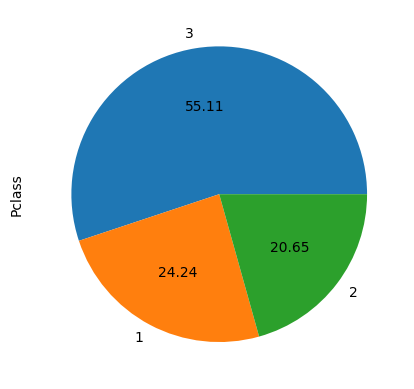

In [55]:
# pie chart to show ticket class proportions of passengers

titanic_data['Pclass'].value_counts().plot(kind='pie', autopct='%.2f')

We don't see the same proportions in the survivor data...upper class passengers now make up almost 40% of survivors and lower class passengers only represent 35% of survivors. 

This indeed does indicate that upper class passengers were given priority in order to survive.

<AxesSubplot: ylabel='Pclass'>

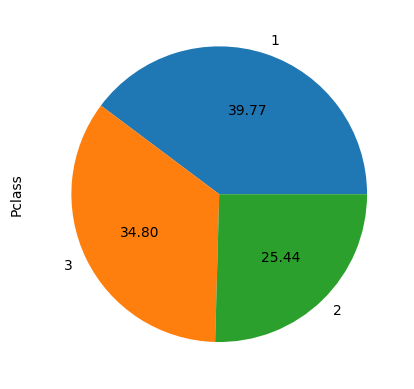

In [54]:
# pie chart to show ticket class proportions of survivors

survivors['Pclass'].value_counts().plot(kind='pie', autopct='%.2f')

Another observation is the overall age distribution of the survivors. We've already established the prioritisation of children when selecting survivors, however there seems to have been a prioritisation of the 30-40 age group as well. 

Despite the representation of all other age groups remaining relatively the same, there is a distinct shift/reduction in the 20-30 age group in the survivor list. 

20's to 30's make up 35% of total passengers but only 33% of survivors, whereas the representation of 30's to 40's grew from 24% to 27%. 

This may be a coincidence however this would warrant further investigation. A possible explanation could be linked to the prioritisation of upper class passengers who are more likely to be older. Giving these passengers preferential treatment (as long as they were of a viable age), could explain this shift.

<AxesSubplot: ylabel='Age'>

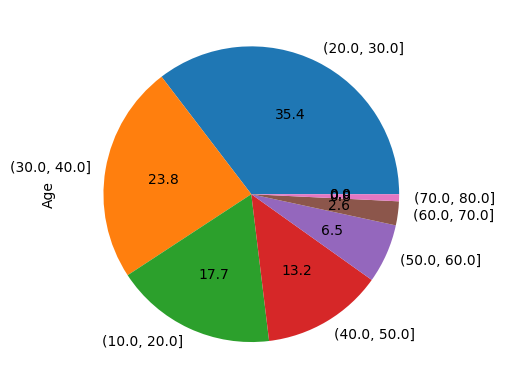

In [63]:
# pie chart to show age group proportions of passengers

age_groups = pd.cut(titanic_data['Age'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf])
age_groups.value_counts().plot(kind='pie', autopct='%.1f')

<AxesSubplot: ylabel='Age'>

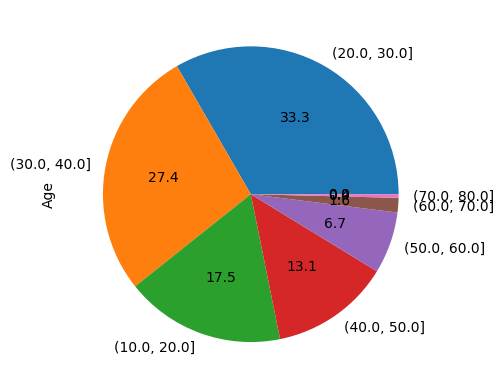

In [90]:
# pie chart to show age group proportions of survivors

age_groups = pd.cut(survivors['Age'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf])
age_groups.value_counts().plot(kind='pie', autopct='%.1f')